Import packages

In [1]:
import matplotlib.pyplot as plt 
from matplotlib.colors import Normalize
from astropy.visualization import ZScaleInterval
import numpy as np 
import astropy
from astropy.io import fits
from astropy.table import Table
import astropy.units as u
from photutils.detection import DAOStarFinder 
from astropy.stats import sigma_clipped_stats
import os
import glob
import warnings
plt.rcParams["font.family"] = "sans-serif"
warnings.filterwarnings('ignore')
z = ZScaleInterval()

Sort files

In [2]:
data_path = "."
allfiles = [os.path.join(data_path, filestub[2:]) for filestub in glob.glob("./palomar_data/*.fits")]
files = {"dither": [], "science": [], "flat": [], "flat_dark": [], "dark": [], "arc": []}


for filename in allfiles:
    if filename[-8:-5].isnumeric():
        image_number = int(filename[-8:-5])
        
        if image_number < 630 and image_number > 511:
            files["science"].append(filename)
        if image_number == 505:
            files["science"].append(filename)
        if image_number < 511 and image_number > 505:
            files["dither"].append(filename)
        if image_number == 47:
            files["arc"].append(filename)
        if image_number < 59 and image_number > 47:
            files["flat"].append(filename)
        if image_number < 30 and image_number > 18:
            files["flat_dark"].append(filename)
        if image_number < 170 and image_number > 158:
            files["dark"].append(filename)

Make an observation log

In [3]:
columns = ["FILENAME", "FILEID", "FILETYPE", "RA", "DEC", "OBJECT", "TIME", "AIRMASS", "EXPTIME"]
filetypes = ["dither", "science", "flat", "flat_dark", "dark", "arc"]
data_dict = {}
for key in files:
    for filename in files[key]:
        current_header = fits.getheader(os.path.join(data_path, filename))
        image_number = int(filename[-8:-5])
        for col in columns:
            if col not in data_dict:
                data_dict[col] = []
            if col == "FILEID":
                data_dict[col].append(image_number)
                continue
            if col == "FILETYPE":
                data_dict[col].append(key)
                continue
            if col == "FILENAME" or col == "EXPTIME":
                if col == "FILENAME":
                    data_dict[col].append(os.path.join(data_path, filename))
                if col == "EXPTIME":
                    data_dict[col].append(current_header[col] * u.second)
            else:
                data_dict[col].append(current_header[col])

data_table = Table()
for key in data_dict:
    data_table[key] = data_dict[key]
data_table.group_by("FILEID").show_in_notebook()
data_table_by_type = data_table.group_by("FILETYPE")

Make a master dark for flats

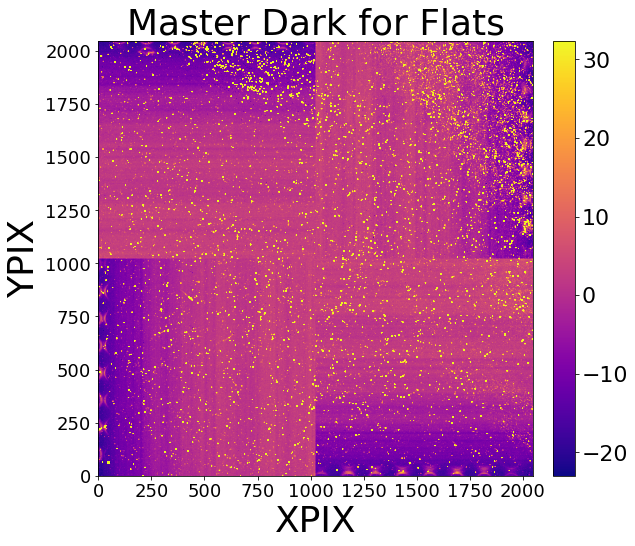

In [4]:
type_mask = data_table_by_type["FILETYPE"] == "flat_dark"
dark_table = data_table_by_type[type_mask]
dark_files = dark_table["FILENAME"]

dark_arrays = []
for dark in dark_files:
    dark_data = fits.getdata(dark)
    dark_arrays.append(dark_data)

master_flat_dark = np.median(dark_arrays, axis=0)
z1, z2 = z.get_limits(master_flat_dark)

fig, ax = plt.subplots()
fig.set_size_inches(9, 8)
cbar = ax.imshow(master_flat_dark, cmap="plasma", norm=Normalize(z1, z2), origin="lower")
ax.set_title("Master Dark for Flats", loc="center", fontsize=36)
ax.set_xlabel("XPIX", fontsize=36)
ax.set_ylabel("YPIX", fontsize=36)
cb = plt.colorbar(cbar, fraction=0.046, pad=0.04);
cb.ax.tick_params(labelsize=22)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.savefig("ay107_masterdarkflat.png", dpi=1200)
plt.show()

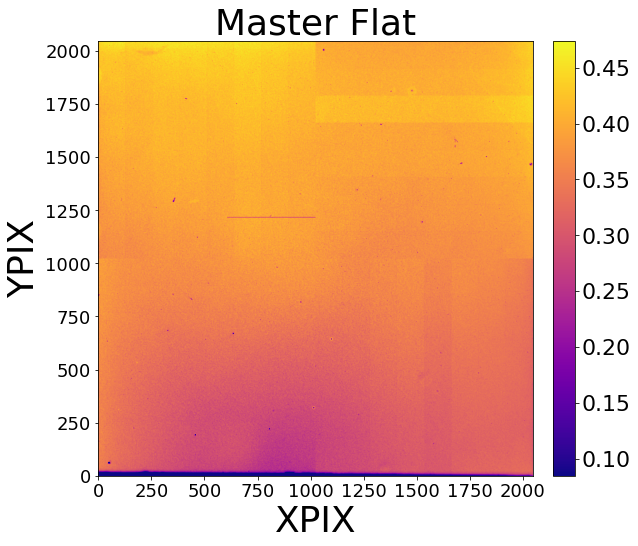

In [5]:
type_mask = data_table_by_type["FILETYPE"] == "flat"
flat_table = data_table_by_type[type_mask]
flat_files = flat_table["FILENAME"]

flat_arrays = []
for flat in flat_files:
    flat_data = fits.getdata(flat)
    flat_exposure = fits.getheader(flat)["EXPTIME"]
    norm_flat_data = (flat_data - master_flat_dark) / flat_exposure
    flat_arrays.append(norm_flat_data)

master_flat = np.median(flat_arrays, axis=0)
master_flat /= np.max(master_flat)
z1, z2 = z.get_limits(master_flat)

fig, ax = plt.subplots()
fig.set_size_inches(9, 8)
cbar = ax.imshow(master_flat, cmap="plasma", norm=Normalize(z1, z2), origin="lower")
ax.set_title("Master Flat", loc="center", fontsize=36)
ax.set_xlabel("XPIX", fontsize=36)
ax.set_ylabel("YPIX", fontsize=36)
cb = plt.colorbar(cbar, fraction=0.046, pad=0.04);
cb.ax.tick_params(labelsize=22)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.savefig("ay107_masterflat.png", dpi=1200)
plt.show()

Make a master dark

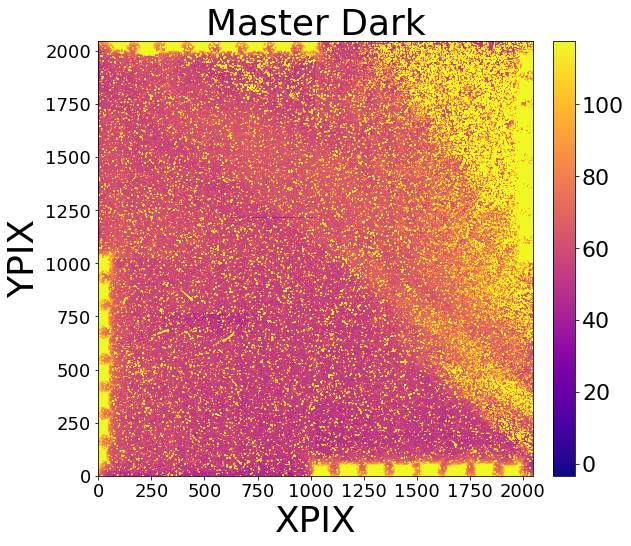

In [6]:
type_mask = data_table_by_type["FILETYPE"] == "dark"
dark_table = data_table_by_type[type_mask]
dark_files = dark_table["FILENAME"]

dark_arrays = []
for dark in dark_files:
    dark_data = fits.getdata(dark)
    #dark_exposure = fits.getheader(dark)["EXPTIME"]
    norm_dark_data = dark_data# / flat_exposure
    dark_arrays.append(norm_dark_data)

master_dark = np.median(dark_arrays, axis=0)
#master_flat /= np.max(master_flat)
z1, z2 = z.get_limits(master_dark)

fig, ax = plt.subplots()
fig.set_size_inches(9, 8)
cbar = ax.imshow(master_dark, cmap="plasma", norm=Normalize(z1, z2), origin="lower")
ax.set_title("Master Dark", loc="center", fontsize=36)
ax.set_xlabel("XPIX", fontsize=36)
ax.set_ylabel("YPIX", fontsize=36)
cb = plt.colorbar(cbar, fraction=0.046, pad=0.04);
cb.ax.tick_params(labelsize=22)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.savefig("ay107_masterdark.png", dpi=1200)
plt.show()

Make a master sky background

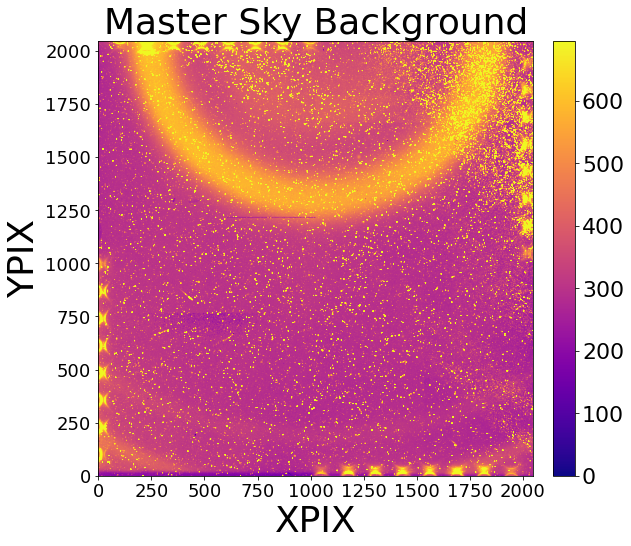

In [7]:
type_mask = data_table_by_type["FILETYPE"] == "dither"
dither_table = data_table_by_type[type_mask]
dither_files = dither_table["FILENAME"]

dither_arrays = []
for dither in dither_files:
    dither_data = fits.getdata(dither)
    dither_exposure = fits.getheader(dither)["EXPTIME"]
    norm_dither_data = (dither_data - master_flat_dark)
    dither_arrays.append(norm_dither_data)

master_sky = np.median(dither_arrays, axis=0)

z1, z2 = z.get_limits(master_sky)
fig, ax = plt.subplots()
fig.set_size_inches(9, 8)
cbar = ax.imshow(master_sky, cmap="plasma", norm=Normalize(z1, z2), origin="lower")
ax.set_title("Master Sky Background", loc="center", fontsize=36)
ax.set_xlabel("XPIX", fontsize=36)
ax.set_ylabel("YPIX", fontsize=36)
cb = plt.colorbar(cbar, fraction=0.046, pad=0.04);
cb.ax.tick_params(labelsize=22)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.savefig("ay107_mastersky.png", dpi=1000)
plt.show()

Make bad pixel map

1374.4889768624387


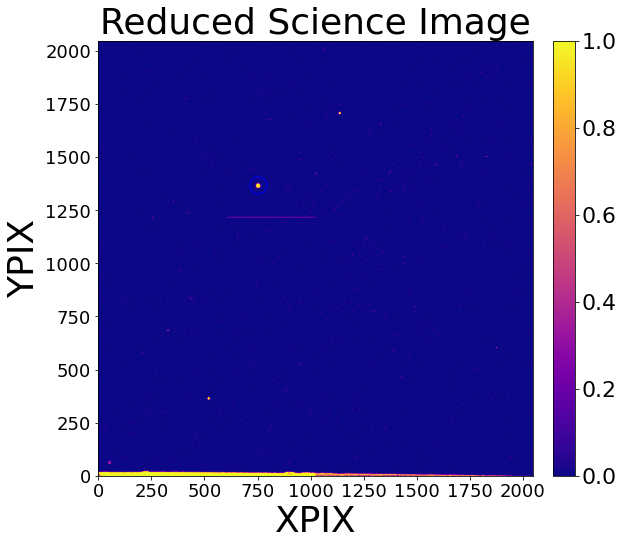

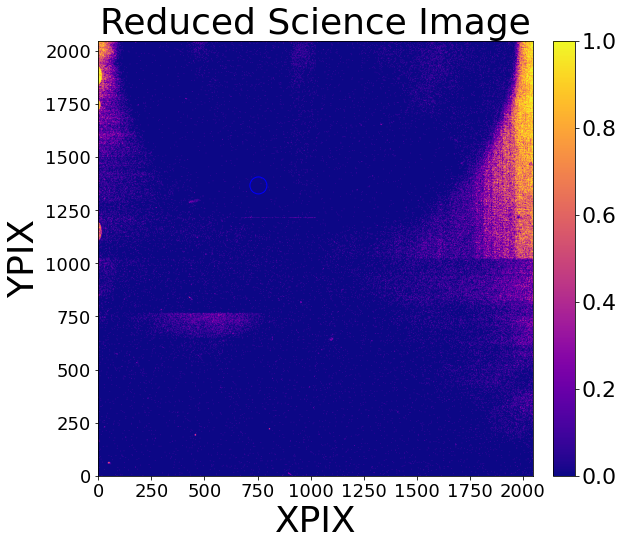

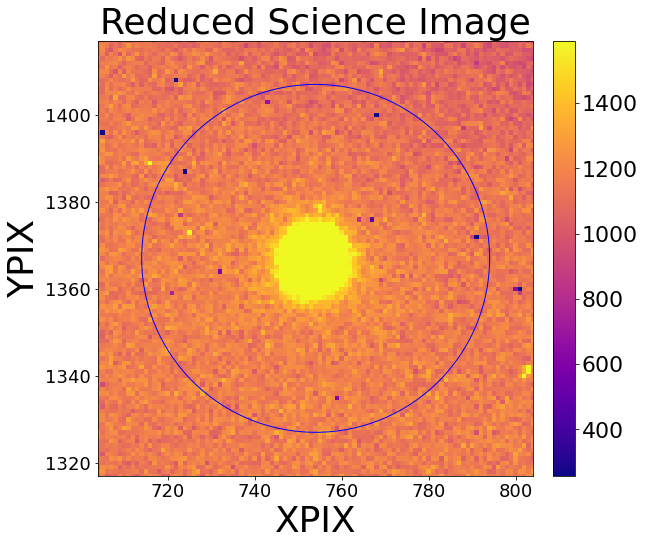

In [8]:
def sigma_mask(data):
    """
    Returns a boolean map of pixels which are 3 standard deviations away from the mean
    """
    clipped_data = astropy.stats.sigma_clip(data, sigma=1)
    rejected_mask = clipped_data.mask
    accepted_mask = 1 - rejected_mask
    rejected_data = rejected_mask * data
    accepted_data = accepted_mask * data
    return rejected_mask, accepted_mask, rejected_data, accepted_data

type_mask = data_table_by_type["FILETYPE"] == "science"
science_table = data_table_by_type[type_mask]
science_files = science_table["FILENAME"]
test_science = fits.getdata(science_files[0])

red_science = (test_science - master_dark) / master_flat;
x_center = 754
y_center = 1367
red_science[np.isnan(red_science)] = 100000
hot_pix_val = np.percentile(red_science, 99.3)
print(hot_pix_val)
hot_pix_mask = red_science > hot_pix_val
cold_pix_mask = red_science < 500

fig, ax = plt.subplots()
fig.set_size_inches(9, 8)
cbar = ax.imshow(hot_pix_mask, origin="lower", cmap="plasma")
ax.set_title("Reduced Science Image", loc="center", fontsize=36)
ax.set_xlabel("XPIX", fontsize=36)
ax.set_ylabel("YPIX", fontsize=36)
#ax.set_xlim(x_center - 50, x_center + 50)
#ax.set_ylim(y_center - 50, y_center + 50)
targ_circle = plt.Circle((x_center, y_center), 40, color="blue", fill=False)
ax.add_patch(targ_circle)
cb = plt.colorbar(cbar, fraction=0.046, pad=0.04);
cb.ax.tick_params(labelsize=22)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.show()

fig, ax = plt.subplots()
fig.set_size_inches(9, 8)
cbar = ax.imshow(cold_pix_mask, origin="lower", cmap="plasma")
ax.set_title("Reduced Science Image", loc="center", fontsize=36)
ax.set_xlabel("XPIX", fontsize=36)
ax.set_ylabel("YPIX", fontsize=36)
#ax.set_xlim(x_center - 50, x_center + 50)
#ax.set_ylim(y_center - 50, y_center + 50)
targ_circle = plt.Circle((x_center, y_center), 40, color="blue", fill=False)
ax.add_patch(targ_circle)
cb = plt.colorbar(cbar, fraction=0.046, pad=0.04);
cb.ax.tick_params(labelsize=22)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.show()

z1, z2 = z.get_limits(red_science)
fig, ax = plt.subplots()
fig.set_size_inches(9, 8)
cbar = ax.imshow(red_science, origin="lower", norm=Normalize(z1, z2), cmap="plasma")
ax.set_title("Reduced Science Image", loc="center", fontsize=36)
ax.set_xlabel("XPIX", fontsize=36)
ax.set_ylabel("YPIX", fontsize=36)
ax.set_xlim(x_center - 50, x_center + 50)
ax.set_ylim(y_center - 50, y_center + 50)
targ_circle = plt.Circle((x_center, y_center), 40, color="blue", fill=False)
ax.add_patch(targ_circle)
cb = plt.colorbar(cbar, fraction=0.046, pad=0.04);
cb.ax.tick_params(labelsize=22)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.show()

Locate target

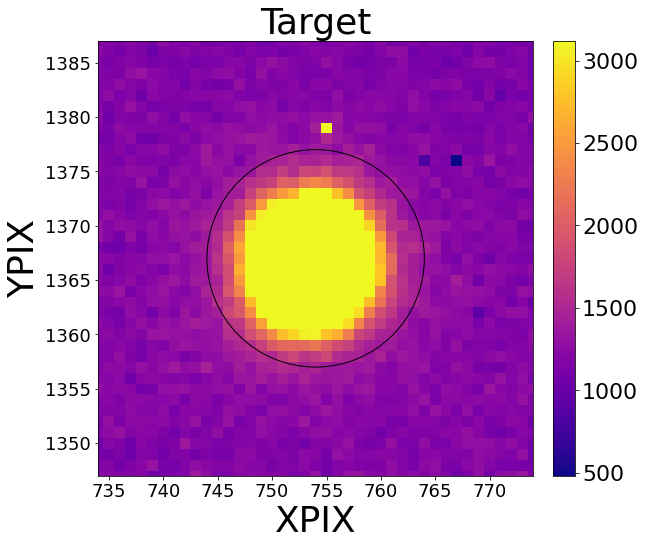

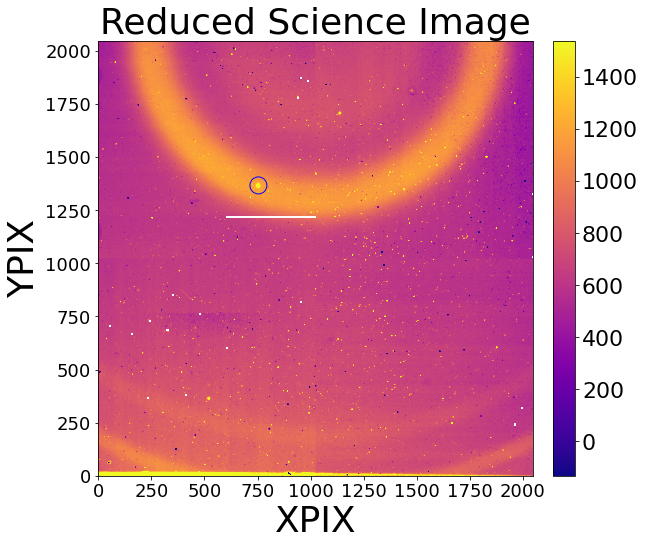

In [9]:
type_mask = data_table_by_type["FILETYPE"] == "science"
science_table = data_table_by_type[type_mask]
science_files = science_table["FILENAME"]
test_science = fits.getdata(science_files[0])

red_science = (test_science - master_dark) / master_flat;
x_center = 754
y_center = 1367

norm_rad = 15

z1, z2 = z.get_limits(red_science[y_center-norm_rad:y_center+norm_rad, x_center-norm_rad:x_center+norm_rad])
fig, ax = plt.subplots()
fig.set_size_inches(9, 8)
cbar = ax.imshow(red_science, origin="lower", norm=Normalize(z1, z2), cmap="plasma")
ax.set_title("Target", loc="center", fontsize=36)
ax.set_xlabel("XPIX", fontsize=36)
ax.set_ylabel("YPIX", fontsize=36)
targ_circle = plt.Circle((x_center, y_center), 10, fill=False)
ax.add_patch(targ_circle)
ax.set_xlim(x_center - 20, x_center + 20)
ax.set_ylim(y_center - 20, y_center + 20)
cb = plt.colorbar(cbar, fraction=0.046, pad=0.04);
cb.ax.tick_params(labelsize=22)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.savefig("ay107_target.png", dpi=1000)
plt.show()

z1, z2 = z.get_limits(red_science)
fig, ax = plt.subplots()
fig.set_size_inches(9, 8)
cbar = ax.imshow(red_science, origin="lower", norm=Normalize(z1, z2), cmap="plasma")
ax.set_title("Reduced Science Image", loc="center", fontsize=36)
ax.set_xlabel("XPIX", fontsize=36)
ax.set_ylabel("YPIX", fontsize=36)
targ_circle = plt.Circle((x_center, y_center), 40, color="blue", fill=False)
ax.add_patch(targ_circle)
cb = plt.colorbar(cbar, fraction=0.046, pad=0.04);
cb.ax.tick_params(labelsize=22)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.savefig("ay107_science.png", dpi=1000)
plt.show()

Test star-finder algorithm

[2418.51737913   28.93799969   29.12340212   21.32908821   21.274503  ]


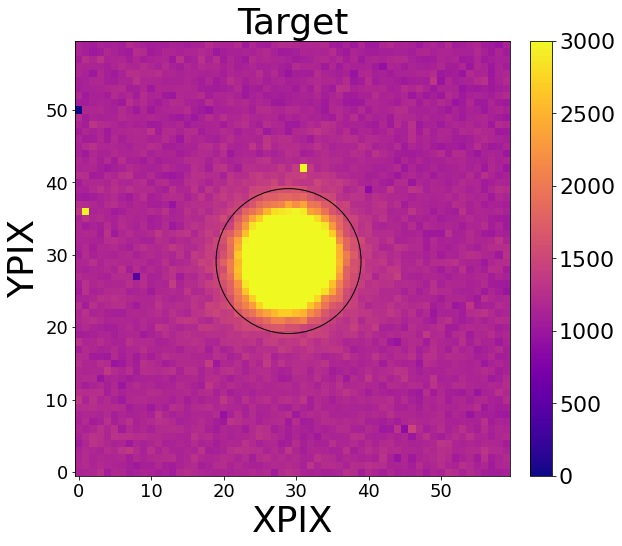

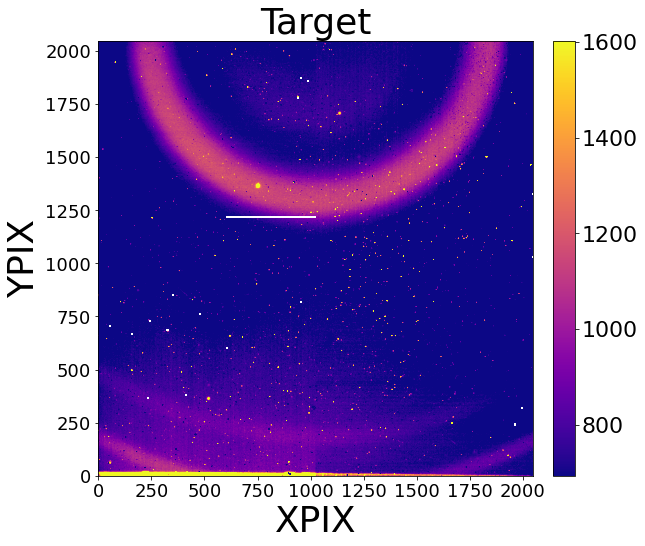

In [10]:
import scipy.optimize as opt
test_science = fits.getdata(science_files[27])
red_science = (test_science - master_dark) / master_flat;
test_x_center = 754
test_y_center = 1367

#test_x_center = 1135
#test_y_center = 1708
norm_rad = 50

delta_pix_fov = 30
mask = np.ones(test_science.shape, dtype=bool)
mask[test_y_center - delta_pix_fov:test_y_center + delta_pix_fov, test_x_center - delta_pix_fov:test_x_center + delta_pix_fov] = False
masked_data = red_science[test_y_center - delta_pix_fov:test_y_center + delta_pix_fov, test_x_center - delta_pix_fov:test_x_center + delta_pix_fov]
mean, median, std = sigma_clipped_stats(masked_data, sigma=3.0)

def Gaussian_2d(xdata_tuple,A,mu_x,mu_y,sigma_x,sigma_y):
    (x, y) = xdata_tuple  
    G= A*np.exp(-(x-mu_x)**2/(2*sigma_x**2) - (y-mu_y)**2/(2*sigma_y**2) )
    return np.ravel(G)

x = np.linspace(0, np.shape(masked_data)[0] - 1, np.shape(masked_data)[0])
y = np.linspace(0, np.shape(masked_data)[0] - 1, np.shape(masked_data)[0])
x, y = np.meshgrid(x, y)
p0 = np.array([3000, 42, 42, 200, 200])
popt, pcov = opt.curve_fit(Gaussian_2d,(x,y), np.ravel(masked_data),p0)
fitted_gaussian = Gaussian_2d((x,y),*popt)
fitted_gaussian = fitted_gaussian.reshape(np.shape(masked_data)[0],np.shape(masked_data)[0]) # to reconstruct a 2D array
print(popt)
z1, z2 = z.get_limits(red_science[test_y_center-norm_rad:test_y_center+norm_rad, test_x_center-norm_rad:test_x_center+norm_rad])
fig, ax = plt.subplots()
fig.set_size_inches(9, 8)
cbar = ax.imshow(masked_data, origin="lower", norm=Normalize(0, 3000), cmap="plasma")
ax.set_title("Target", loc="center", fontsize=36)
ax.set_xlabel("XPIX", fontsize=36)
ax.set_ylabel("YPIX", fontsize=36)
targ_circle = plt.Circle((popt[1], popt[2]), 10, fill=False)
ax.add_patch(targ_circle)
cb = plt.colorbar(cbar, fraction=0.046, pad=0.04);
cb.ax.tick_params(labelsize=22)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.show()

fig, ax = plt.subplots()
fig.set_size_inches(9, 8)
cbar = ax.imshow(red_science, origin="lower", norm=Normalize(z1, z2), cmap="plasma")
ax.set_title("Target", loc="center", fontsize=36)
ax.set_xlabel("XPIX", fontsize=36)
ax.set_ylabel("YPIX", fontsize=36)
#targ_circle = plt.Circle((x_centroid, y_centroid), 10, fill=False)
#ax.add_patch(targ_circle)
#ax.set_xlim(x_centroid - delta_pix_fov, x_centroid + delta_pix_fov)
#ax.set_ylim(y_centroid - delta_pix_fov, y_centroid + delta_pix_fov)
cb = plt.colorbar(cbar, fraction=0.046, pad=0.04);
cb.ax.tick_params(labelsize=22)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.show()

Define aperture photometry functions

In [11]:
height = len(red_science)
width = len(red_science[0])
x_center = 754
y_center = 1367



def aperture_mask(h, w, radius, x_target, y_target):
    """ 
    Code that generates aperture mask
    """
    
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - x_target)**2 + (Y-y_target)**2)

    mask = dist_from_center <= radius
    n_pix = np.sum(mask)
    return mask, n_pix

def annulus_mask(h, w, inner_radius, outer_radius, x_target, y_target):
    """ 
    Code that generates an annulus mask
    """
    
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - x_target)**2 + (Y-y_target)**2)

    mask = (dist_from_center <= outer_radius) & (dist_from_center >= inner_radius)
    n_pix = np.sum(mask)
    return mask, n_pix

def calc_median(data, ann_mask, x_target, y_target, outer_radius):
    annular_data = np.multiply(data, ann_mask)
    annular_vals = []
    for x_idx in range(x_target - outer_radius, x_target + outer_radius + 1):
        for y_idx in range(y_target - outer_radius, y_target + outer_radius + 1):
            if annular_data[y_idx][x_idx] != 0:
                annular_vals.append(annular_data[y_idx][x_idx]) 
    return np.median(annular_vals)

def aperture_mask(h, w, radius, x_target, y_target):
    """ 
    Code that generates aperture mask
    """
    
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - x_target)**2 + (Y-y_target)**2)

    mask = dist_from_center <= radius
    n_pix = np.sum(mask)
    return mask, n_pix

Generate raw lightcurve for target

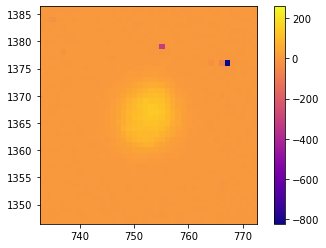

In [12]:
type_mask = data_table_by_type["FILETYPE"] == "science"
science_table = data_table_by_type[type_mask]
science_table.group_by("FILEID").show_in_notebook()
sorted_science_files = science_table.group_by("FILEID")["FILENAME"]
gain = fits.getheader(science_files[0])['DETGAIN']
height = len(master_flat)
width = len(master_flat[0])
x_center = 747
y_center = 1364

target_counts = []
target_errors = []
for science_file in sorted_science_files:
    science_data = fits.getdata(science_file)
    red_science = (science_data - master_dark - master_sky) / master_flat
    
    # Fit to Gaussian
    delta_pix_fov = 50
    mask = np.ones(red_science.shape, dtype=bool)
    mask[y_center - delta_pix_fov:y_center + delta_pix_fov, x_center - delta_pix_fov:x_center + delta_pix_fov] = False
    masked_data = red_science[y_center - delta_pix_fov:y_center + delta_pix_fov, x_center - delta_pix_fov:x_center + delta_pix_fov]
    mean, median, std = sigma_clipped_stats(masked_data, sigma=3.0)

    def Gaussian_2d(xdata_tuple,A,mu_x,mu_y,sigma_x,sigma_y):
        (x, y) = xdata_tuple  
        G= A*np.exp(-(x-mu_x)**2/(2*sigma_x**2) - (y-mu_y)**2/(2*sigma_y**2) )
        return np.ravel(G)

    x = np.linspace(0, np.shape(masked_data)[0] - 1, np.shape(masked_data)[0])
    y = np.linspace(0, np.shape(masked_data)[0] - 1, np.shape(masked_data)[0])
    x, y = np.meshgrid(x, y)
    p0 = np.array([9000, 42, 42, 10, 10])
    popt, pcov = opt.curve_fit(Gaussian_2d,(x,y), np.ravel(masked_data),p0)
    fitted_gaussian = Gaussian_2d((x,y),*popt)
    fitted_gaussian = fitted_gaussian.reshape(np.shape(masked_data)[0],np.shape(masked_data)[0]) # to reconstruct a 2D array
    x_centroid = popt[1] + x_center - delta_pix_fov
    y_centroid = popt[2] + y_center - delta_pix_fov
    
    mask, n_pix = aperture_mask(height, width, 10, x_centroid, y_centroid)
    count = np.nansum(np.multiply(red_science, mask)) / fits.getheader(science_files[0])['EXPTIME']
    target_counts.append(count)
    error = np.sqrt(np.nansum(np.multiply(red_science / gain, mask)**2 / fits.getheader(science_files[0])['EXPTIME']))
    target_errors.append(error)
    x_center = 753
    y_center = 1367

Plot raw lightcurve for target

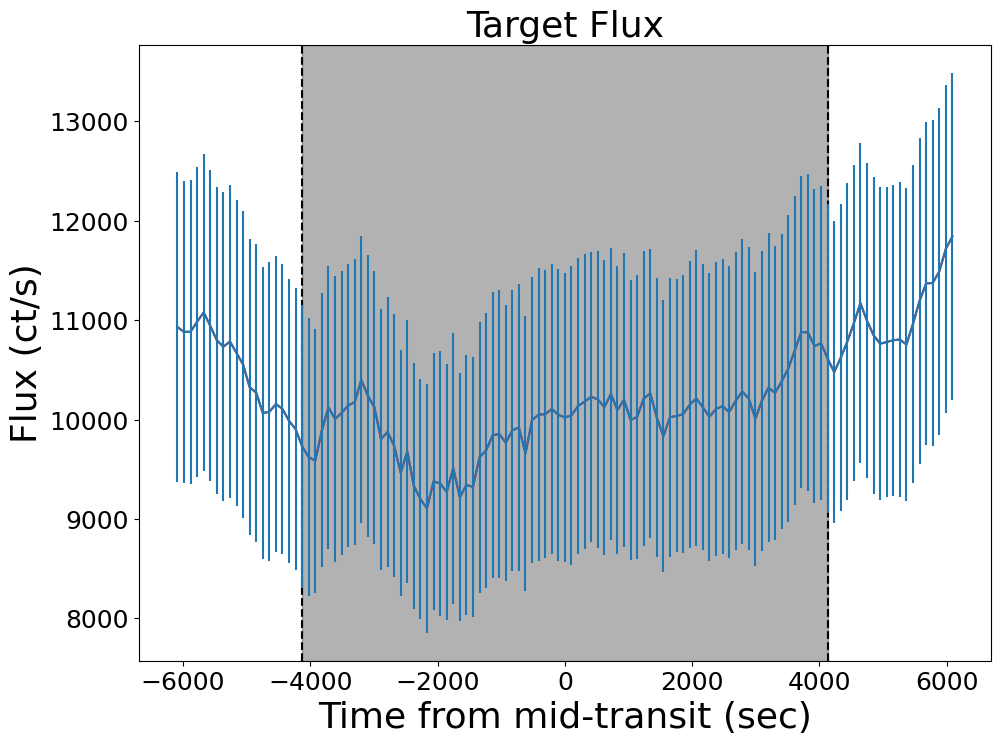

In [90]:
x = np.arange(len(sorted_science_files))
n_frame = 94 - 11
t_frame_sec = (108 * 60) / n_frame
mid_frame = np.floor((94 - 11) / 2)
delta_tframe = (len(x) - mid_frame) * t_frame_sec 
transit_tframe = (94 - mid_frame) * t_frame_sec 
t_range = np.linspace(-delta_tframe, delta_tframe, len(x))

fig, ax = plt.subplots()
fig.set_size_inches(11, 8)
ax.axvline(-transit_tframe, linestyle="dashed", color="black")
ax.axvline(transit_tframe, linestyle="dashed", color="black")
ax.axvspan(-transit_tframe, transit_tframe, color="black", alpha=0.3)
ax.plot(t_range, target_counts, color="red");
ax.errorbar(t_range, target_counts, yerr=target_errors)
ax.set_xlabel("Time from mid-transit (sec)", fontsize=26)
ax.set_ylabel("Flux (ct/s)", fontsize=26)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
ax.set_title('Target Flux', loc="center", fontsize=26);
plt.savefig("ay107_lc.png", dpi=1000)
plt.show()

Bin observations for target

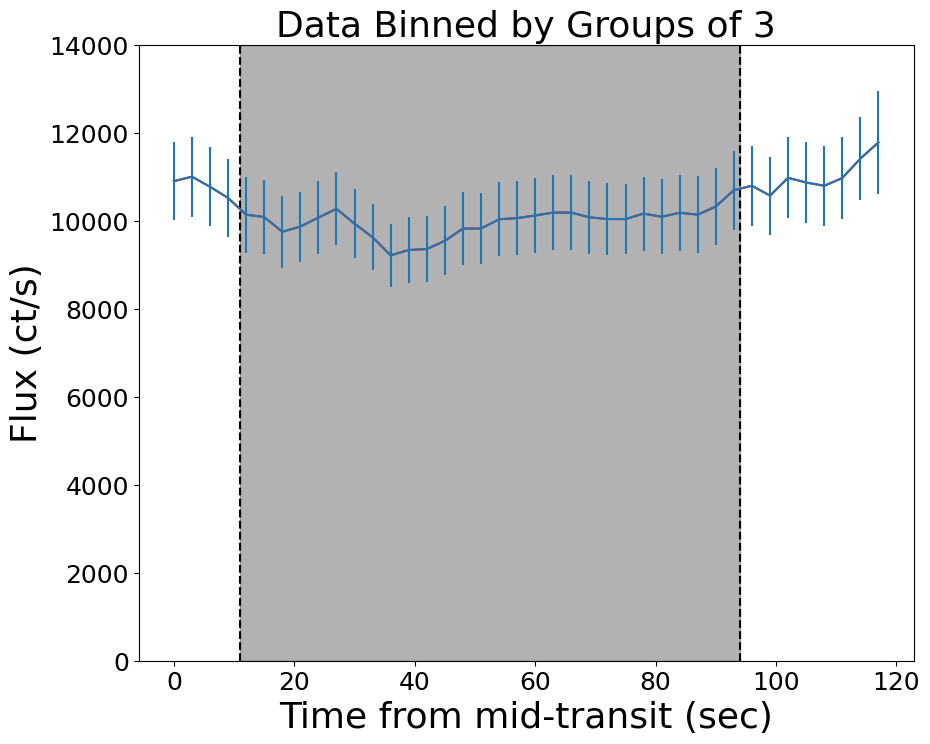

In [70]:
counts3 = []
errors3 = []
for i in range(39):
    new_index = 3*i
    one = target_counts[new_index]
    two = target_counts[new_index+1]
    three = target_counts[new_index+2]
    average = (one+two+three)/3
    counts3.append(average)
    err1 = target_errors[new_index]
    err2 = target_errors[new_index+1]
    err3 = target_errors[new_index+2]
    new_err = ((err1**2 + err2**2 + err3**2))**.5 / 3
    errors3.append(new_err)
final_counts3 = (target_counts[-1] + target_counts[-2]) / 2
counts3.append(final_counts3)
final_errors3 = ((target_errors[-1]**2 + target_errors[-2]**2))**.5 / 2
errors3.append(final_errors3)
x3 = np.arange(len(counts3))

fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
ax.axvline(11, linestyle="dashed", color="black")
ax.axvline(94, linestyle="dashed", color="black")
ax.axvspan(11, 94, color="black", alpha=0.3)
ax.plot(x3 * 3, counts3, color="red");
ax.errorbar(x3 * 3, counts3, yerr=errors3)
ax.set_xlabel("Time from mid-transit (sec)", fontsize=26)
ax.set_ylabel("Flux (ct/s)", fontsize=26)
ax.set_ylim(0, 14000)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
ax.set_title('Data Binned by Groups of 3', loc="center", fontsize=26);
plt.savefig("ay107_binnedlc.png", dpi=1000)
plt.show()

Aperture photometry on FoV star

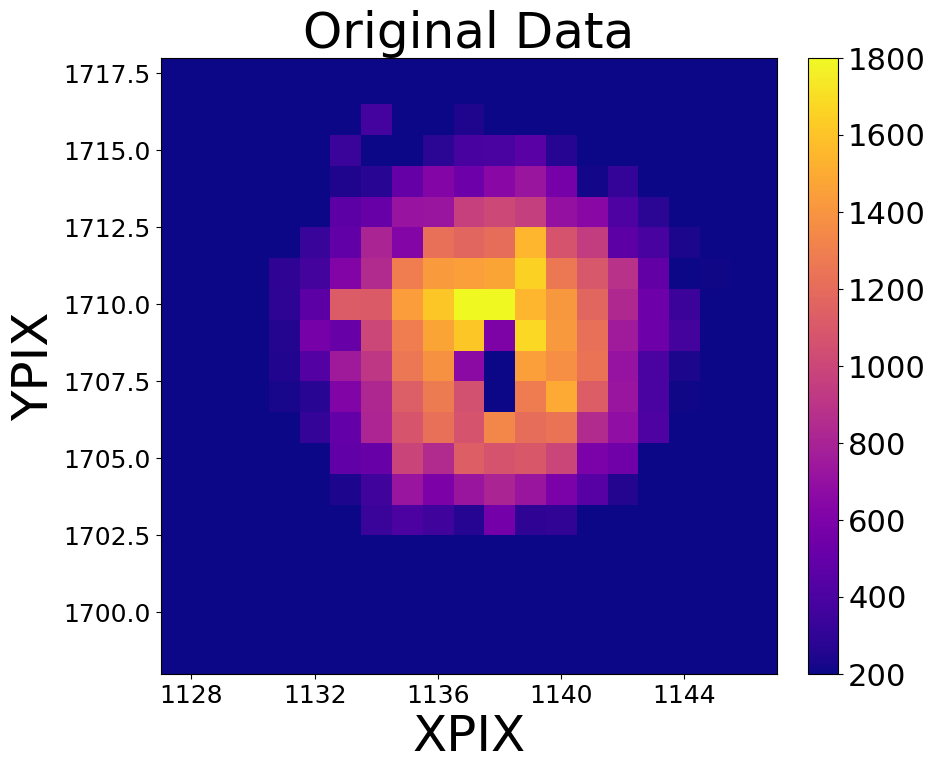

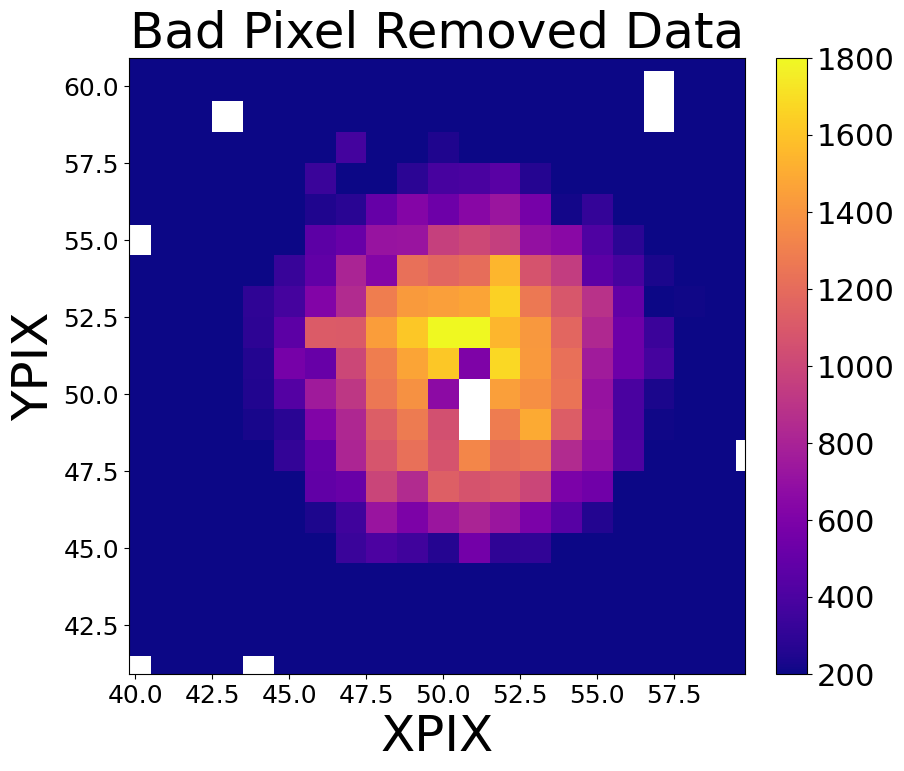

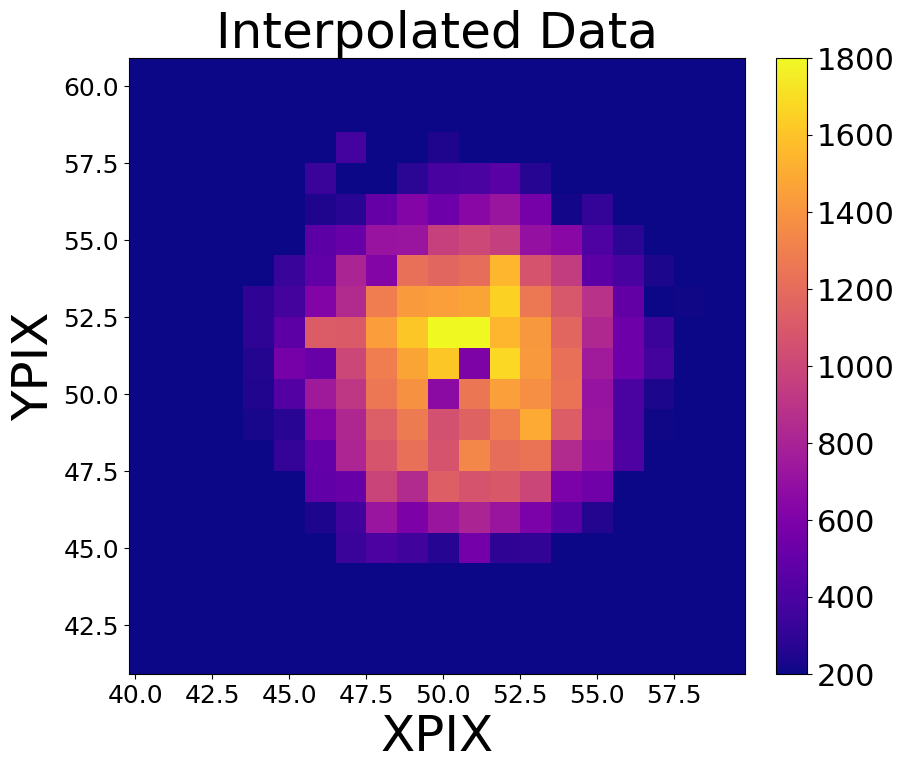

In [87]:
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

fov1_x_center = 1130
fov1_y_center = 1705

fov1_counts = []
fov1_errors = []
for idx, science_file in enumerate(sorted_science_files):
    science_data = fits.getdata(science_file)
    red_science = (science_data - master_dark - master_sky) / master_flat
    
    x_center = fov1_x_center
    y_center = fov1_y_center
    
    if idx == 1:
        fig, ax = plt.subplots()
        fig.set_size_inches(10, 8)
        cbar = ax.imshow(red_science, origin="lower", norm=Normalize(200, 1800), cmap="plasma")
        ax.set_title("Original Data", loc="center", fontsize=36)
        ax.set_xlabel("XPIX", fontsize=36)
        ax.set_ylabel("YPIX", fontsize=36)
        ax.set_xlim(x_center - 40, x_center + 40)
        ax.set_ylim(y_center - 40, y_center + 40)
        cb = plt.colorbar(cbar, fraction=0.046, pad=0.04);
        cb.ax.tick_params(labelsize=22)
        ax.set_xlim(x_center - 10, x_center + 10)
        ax.set_ylim(y_center - 10, y_center + 10)
        ax.xaxis.set_major_locator(MultipleLocator(4))
        ax.xaxis.set_major_locator(MultipleLocator(4))
        plt.xticks(fontsize = 18)
        plt.yticks(fontsize = 18)
        plt.savefig("ay107_uninterped.png", dpi=1000)
        plt.show()
    
    # Fit to Gaussian
    delta_pix_fov = 50
    mask = np.ones(red_science.shape, dtype=bool)
    mask[y_center - delta_pix_fov:y_center + delta_pix_fov, x_center - delta_pix_fov:x_center + delta_pix_fov] = False
    masked_data = red_science[y_center - delta_pix_fov:y_center + delta_pix_fov, x_center - delta_pix_fov:x_center + delta_pix_fov]
    mean, median, std = sigma_clipped_stats(masked_data, sigma=3.0)
    
    def Gaussian_2d(xdata_tuple,A,mu_x,mu_y,sigma_x,sigma_y,offset):
        (x, y) = xdata_tuple  
        G= A*np.exp(-(x-mu_x)**2/(2*sigma_x**2) - (y-mu_y)**2/(2*sigma_y**2) ) + offset
        return np.ravel(G)

    x = np.linspace(0, np.shape(masked_data)[0] - 1, np.shape(masked_data)[0])
    y = np.linspace(0, np.shape(masked_data)[0] - 1, np.shape(masked_data)[0])
    x, y = np.meshgrid(x, y)
    med_bkg = np.median(masked_data[0])
    p0 = np.array([1800, 50, 50, 2, 2, med_bkg])
    popt, pcov = opt.curve_fit(Gaussian_2d,(x,y), np.ravel(masked_data),p0)
    
    fitted_gaussian = Gaussian_2d((x,y),*popt)
    hot_pix_val = np.percentile(masked_data, 10)
    hot_pix_mask = masked_data < hot_pix_val
    masked_data[hot_pix_mask] = np.nan
    kernel = Gaussian2DKernel(x_stddev= 4 / 2.355)
    fixed_image = interpolate_replace_nans(masked_data, kernel)

    fitted_gaussian = fitted_gaussian.reshape(np.shape(masked_data)[0],np.shape(masked_data)[0]) # to reconstruct a 2D array
    x_centroid = popt[1] + x_center - delta_pix_fov
    y_centroid = popt[2] + y_center - delta_pix_fov
    
    height = len(fixed_image)
    width = len(fixed_image[0])
    
    
    mask, n_pix = aperture_mask(height, width, 8, popt[1], popt[2])
    count = np.nansum(np.multiply(fixed_image, mask)) / fits.getheader(science_files[0])['EXPTIME']
    fov1_counts.append(count)
    error = np.sqrt(np.nansum(np.multiply(fixed_image / gain, mask)**2 / fits.getheader(science_files[0])['EXPTIME']))
    fov1_errors.append(error)
    
    
    if idx == 1:
        fig, ax = plt.subplots()
        fig.set_size_inches(10, 8)
        cbar = ax.imshow(masked_data, origin="lower", norm=Normalize(200, 1800), cmap="plasma")
        ax.set_title("Bad Pixel Removed Data", loc="center", fontsize=36)
        ax.set_xlabel("XPIX", fontsize=36)
        ax.set_ylabel("YPIX", fontsize=36)
        targ_circle = plt.Circle((x_centroid, y_centroid), 40, color="blue", fill=False)
        ax.add_patch(targ_circle)
        cb = plt.colorbar(cbar, fraction=0.046, pad=0.04);
        cb.ax.tick_params(labelsize=22)
        ax.set_xlim(popt[1] - 8, popt[1] + 12)
        ax.set_ylim(popt[2] - 10, popt[2] + 10)
        plt.xticks(fontsize = 18)
        plt.yticks(fontsize = 18)
        plt.savefig("ay107_badpix.png", dpi=1000)
        plt.show()

        fig, ax = plt.subplots()
        fig.set_size_inches(10, 8)
        cbar = ax.imshow(fixed_image, origin="lower", norm=Normalize(200, 1800), cmap="plasma")
        ax.set_title("Interpolated Data", loc="center", fontsize=36)
        ax.set_xlabel("XPIX", fontsize=36)
        ax.set_ylabel("YPIX", fontsize=36)
        targ_circle = plt.Circle((x_centroid, y_centroid), 40, color="blue", fill=False)
        ax.add_patch(targ_circle)
        cb = plt.colorbar(cbar, fraction=0.046, pad=0.04);
        cb.ax.tick_params(labelsize=22)
        ax.set_xlim(popt[1] - 8, popt[1] + 12)
        ax.set_ylim(popt[2] - 10, popt[2] + 10)
        plt.xticks(fontsize = 18)
        plt.yticks(fontsize = 18)
        plt.savefig("ay107_interped.png", dpi=1000)
        plt.show()
    
    
    fov1_x_center = 1137
    fov1_y_center = 1708

Plot lightcurve for FoV star 1

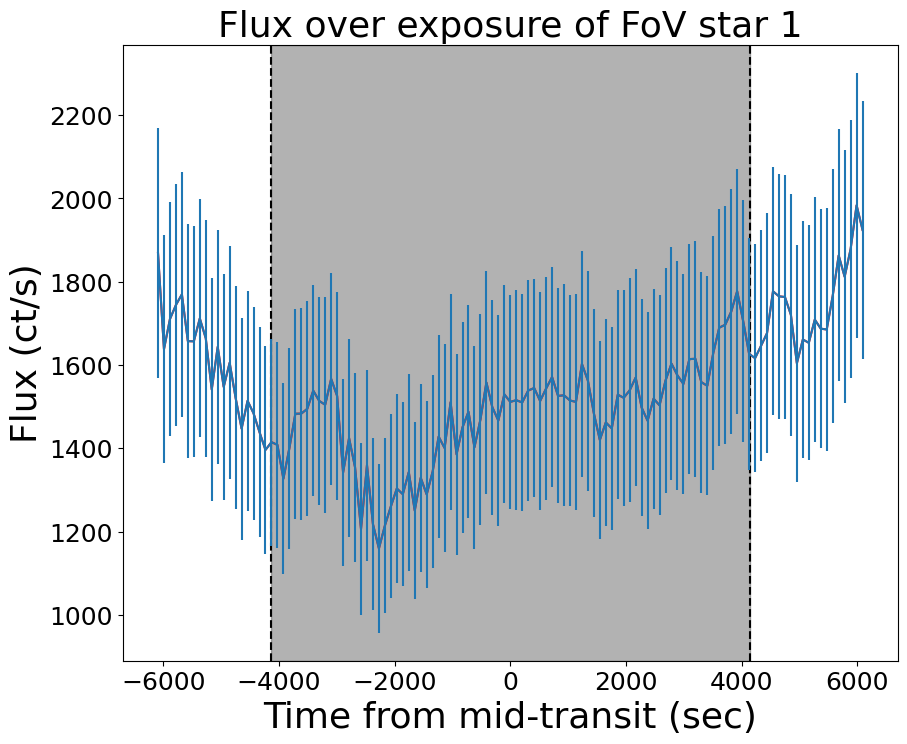

In [71]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
ax.axvline(-transit_tframe, linestyle="dashed", color="black")
ax.axvline(transit_tframe, linestyle="dashed", color="black")
ax.axvspan(-transit_tframe, transit_tframe, color="black", alpha=0.3)
ax.plot(t_range, fov1_counts, color="red");
ax.errorbar(t_range, fov1_counts, yerr=fov1_errors)
ax.set_xlabel("Time from mid-transit (sec)", fontsize=26)
ax.set_ylabel("Flux (ct/s)", fontsize=26)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
ax.set_title("Flux over exposure of FoV star 1", loc="center", fontsize=26);
plt.savefig("ay107_lc_fov1.png", dpi=1000)
plt.show()

Generate lightcurve for FoV star 2

In [16]:
fov2_x_center = 521 #515
fov2_y_center = 365 #363

red_science = (test_science - master_dark) / master_flat
norm_rad = 12
norm_frame = red_science[y_center-norm_rad:y_center+norm_rad, x_center-norm_rad:x_center+norm_rad]
height = len(red_science)
width = len(red_science[0])

fov2_counts = []
fov2_errors = []
for science_file in sorted_science_files:
    science_data = fits.getdata(science_file)
    red_science = (science_data - master_dark - master_sky) / master_flat
    
    x_center = fov2_x_center
    y_center = fov2_y_center
    
    # Fit to Gaussian
    delta_pix_fov = 50
    mask = np.ones(red_science.shape, dtype=bool)
    mask[y_center - delta_pix_fov:y_center + delta_pix_fov, x_center - delta_pix_fov:x_center + delta_pix_fov] = False
    masked_data = red_science[y_center - delta_pix_fov:y_center + delta_pix_fov, x_center - delta_pix_fov:x_center + delta_pix_fov]
    mean, median, std = sigma_clipped_stats(masked_data, sigma=3.0)

    def Gaussian_2d(xdata_tuple,A,mu_x,mu_y,sigma_x,sigma_y,offset):
        (x, y) = xdata_tuple  
        G= A*np.exp(-(x-mu_x)**2/(2*sigma_x**2) - (y-mu_y)**2/(2*sigma_y**2) ) + offset
        return np.ravel(G)

    x = np.linspace(0, np.shape(masked_data)[0] - 1, np.shape(masked_data)[0])
    y = np.linspace(0, np.shape(masked_data)[0] - 1, np.shape(masked_data)[0])
    x, y = np.meshgrid(x, y)
    med_bkg = np.median(masked_data[0])
    p0 = np.array([1800, 50, 50, 2, 2, med_bkg])
    popt, pcov = opt.curve_fit(Gaussian_2d,(x,y), np.ravel(masked_data),p0)#, bounds=((1000, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf), (np.inf, np.inf, np.inf, np.inf, np.inf, np.inf)))
    
    fitted_gaussian = Gaussian_2d((x,y),*popt)
    if popt[0] < 1000:
        print(popt, idx)
        z1, z2 = z.get_limits(masked_data)
        fig, ax = plt.subplots()
        cbar = ax.imshow(masked_data, norm=Normalize(z1, 1800), origin="lower")
        targ_circle = plt.Circle((popt[1], popt[2]), 10, fill=False)
        ax.add_patch(targ_circle)
        plt.colorbar(cbar)
        plt.show()
        break
    fitted_gaussian = fitted_gaussian.reshape(np.shape(masked_data)[0],np.shape(masked_data)[0]) # to reconstruct a 2D array
    x_centroid = popt[1] + x_center - delta_pix_fov
    y_centroid = popt[2] + y_center - delta_pix_fov
    
    mask, n_pix = aperture_mask(height, width, 8, x_centroid, y_centroid)
    count = np.nansum(np.multiply(red_science, mask)) / fits.getheader(science_files[0])['EXPTIME']
    fov2_counts.append(count)
    error = np.sqrt(np.nansum(np.multiply(red_science / gain, mask)**2 / fits.getheader(science_files[0])['EXPTIME']))
    fov2_errors.append(error)



Plot lightcurve for FoV star 2

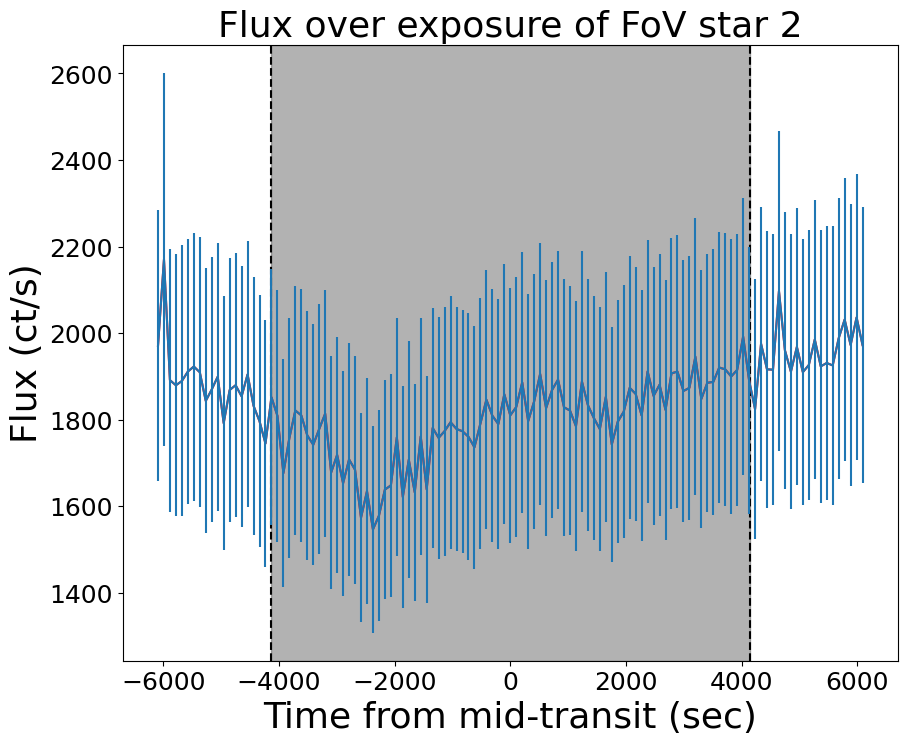

In [72]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
ax.axvline(-transit_tframe, linestyle="dashed", color="black")
ax.axvline(transit_tframe, linestyle="dashed", color="black")
ax.axvspan(-transit_tframe, transit_tframe, color="black", alpha=0.3)
ax.plot(t_range, fov2_counts, color="red");
ax.errorbar(t_range, fov2_counts, yerr=fov2_errors)
ax.set_xlabel("Time from mid-transit (sec)", fontsize=26)
ax.set_ylabel("Flux (ct/s)", fontsize=26)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
ax.set_title("Flux over exposure of FoV star 2", loc="center", fontsize=26);
plt.savefig("ay107_lc_fov2.png", dpi=1000)
plt.show()

Apply variation correction to target lightcurve

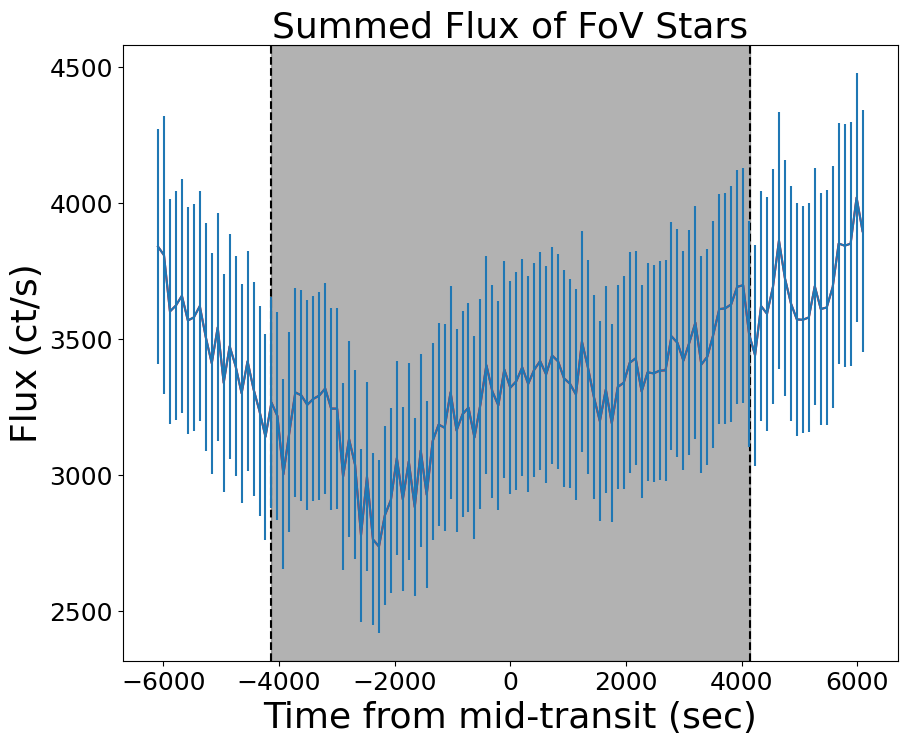

In [73]:
fov_sum = np.array(fov1_counts) + np.array(fov2_counts)
fov_sum_errors = (np.array(fov1_errors)**2 + np.array(fov2_errors)**2)**.5


fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
ax.axvline(-transit_tframe, linestyle="dashed", color="black")
ax.axvline(transit_tframe, linestyle="dashed", color="black")
ax.axvspan(-transit_tframe, transit_tframe, color="black", alpha=0.3)
ax.plot(t_range, fov_sum, color="red");
ax.errorbar(t_range, fov_sum, yerr=fov_sum_errors)
ax.set_xlabel("Time from mid-transit (sec)", fontsize=26)
ax.set_ylabel("Flux (ct/s)", fontsize=26)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
ax.set_title("Summed Flux of FoV Stars", loc="center", fontsize=26);
plt.savefig("ay107_lc_fov_summed.png", dpi=1000)
plt.show()

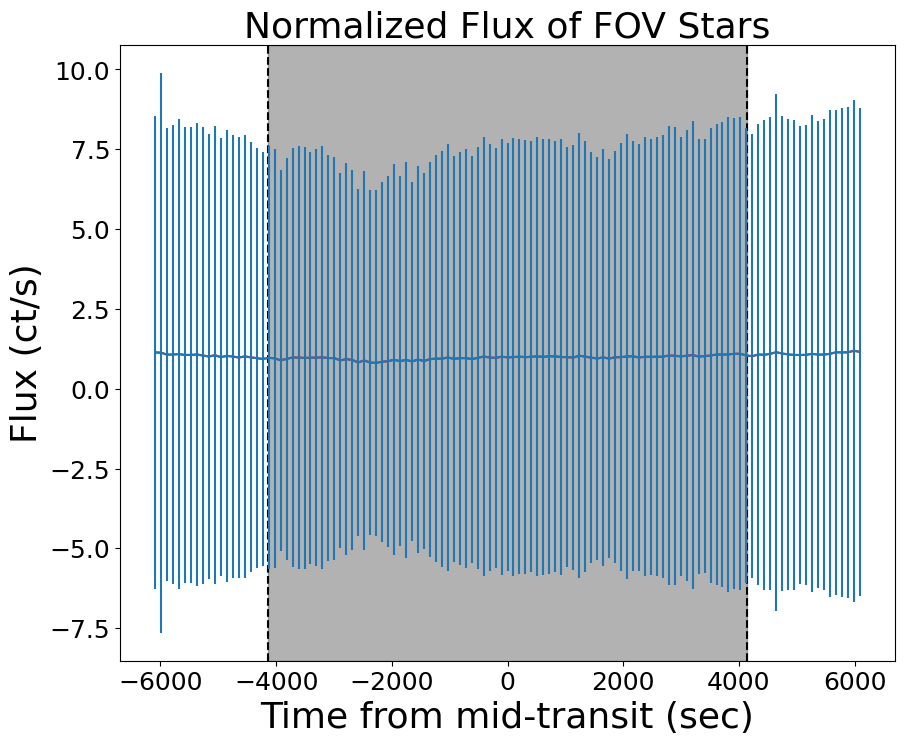

In [75]:
mean_counts = np.mean(fov_sum)
normal_counts = fov_sum / mean_counts
mean_errors = 0
for error in fov_sum_errors:
    mean_errors += error**2
mean_errors = mean_errors**.5 / len(fov_sum)

normal_error = np.abs(fov_sum_errors**2 / mean_counts - mean_errors**2 * fov_sum / mean_counts**2)**.5

fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
ax.axvline(-transit_tframe, linestyle="dashed", color="black")
ax.axvline(transit_tframe, linestyle="dashed", color="black")
ax.axvspan(-transit_tframe, transit_tframe, color="black", alpha=0.3)
ax.plot(t_range, normal_counts, color="red");
ax.errorbar(t_range, normal_counts, yerr=normal_error)
ax.set_xlabel("Time from mid-transit (sec)", fontsize=26)
ax.set_ylabel("Flux (ct/s)", fontsize=26)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
ax.set_title("Normalized Flux of FOV Stars", loc="center", fontsize=26);
plt.savefig("ay107_lc_fov_normalized.png", dpi=1000)
plt.show()

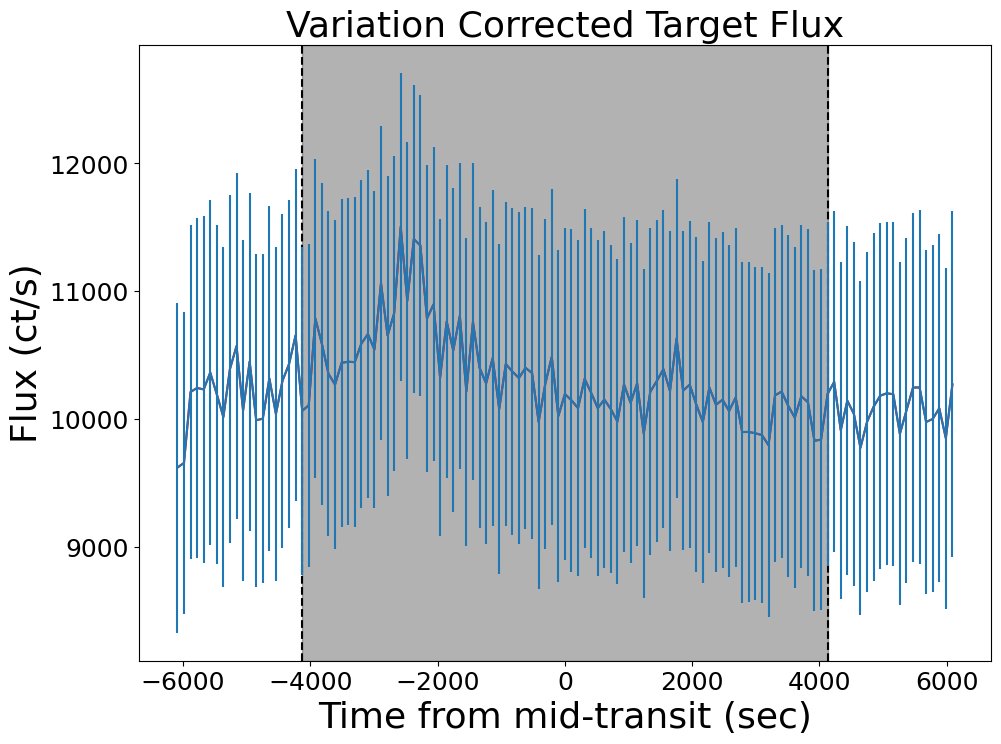

In [77]:
corrected_counts = target_counts / normal_counts
corrected_error = np.abs(np.array(target_errors)**2 / normal_counts - normal_error**2 * target_counts / normal_counts**2)**.5

fig, ax = plt.subplots()
fig.set_size_inches(11, 8)
ax.axvline(-transit_tframe, linestyle="dashed", color="black")
ax.axvline(transit_tframe, linestyle="dashed", color="black")
ax.axvspan(-transit_tframe, transit_tframe, color="black", alpha=0.3)
ax.plot(t_range, corrected_counts, color="red");
ax.errorbar(t_range, corrected_counts, yerr=corrected_error)
ax.set_xlabel("Time from mid-transit (sec)", fontsize=26)
ax.set_ylabel("Flux (ct/s)", fontsize=26)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
ax.set_title("Variation Corrected Target Flux", loc="center", fontsize=26);
plt.savefig("ay107_lc_fov_corrected.png", dpi=1000)
plt.show()

TOI-plots

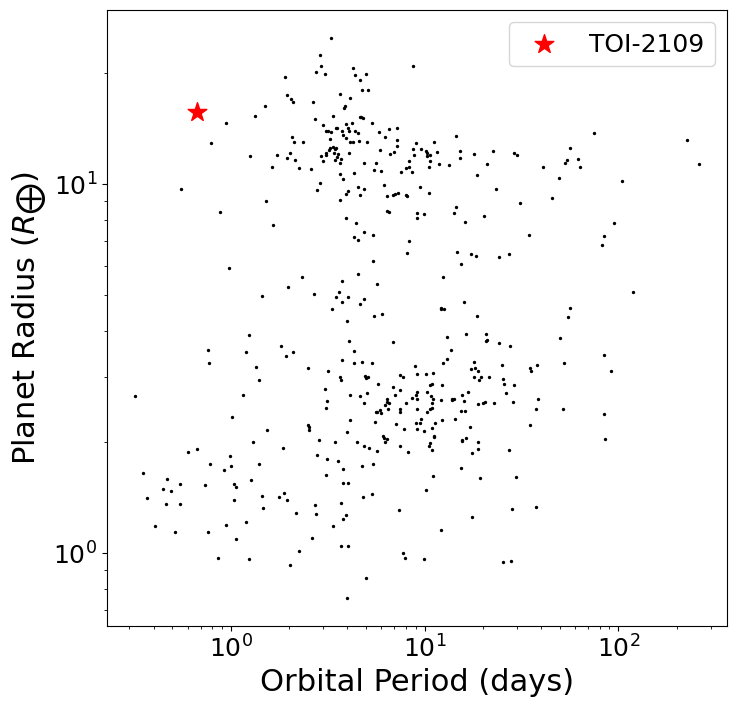

In [88]:
tois = Table.read('toi_table.tbl', format='ipac')
tois = tois[tois["tfopwg_disp"] == "CP"]
tois = tois[~np.isnan(tois["pl_orbper"])]
tois = tois[~np.isnan(tois["pl_rade"])]

fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
ax.scatter(tois["pl_orbper"], tois["pl_rade"], color="black", s=2)
ax.scatter(0.67249, 15.7288, color="red", s=200, marker="*", label="TOI-2109")
ax.set_xlabel("Orbital Period (days)", fontsize=22)
ax.set_ylabel(r"Planet Radius ($R_{\bigoplus}$)", fontsize=22)
ax.set_xscale("log")
ax.set_yscale("log")
plt.xticks(fontsize = 18)
plt.yticks(fontsize  = 18)
plt.legend(prop = { "size": 18 })
plt.savefig("ay107_period_rad.png", dpi=1000)